    Author: Eswar Lakshminarayanan

### Importing dependencies

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from random import sample
import matplotlib.pyplot as plt 
from folium.plugins import HeatMap
import folium
import folium.plugins as plugins
%matplotlib inline

### Random sampling

In [2]:
n = 1764258 #number of records in file
s = 200000 #desired sample size
skip = sorted(sample(range(1,n),n-s))
df = pd.read_csv("new_level1_trajectory.csv",header=0,skiprows=skip)

### Filter really short and long trajectories

In [3]:
df = df.loc[(df.seq_len>10) & (df.seq_len<1500)]

In [4]:
df.shape

(3409396, 5)

### Trajectory Length Distribution

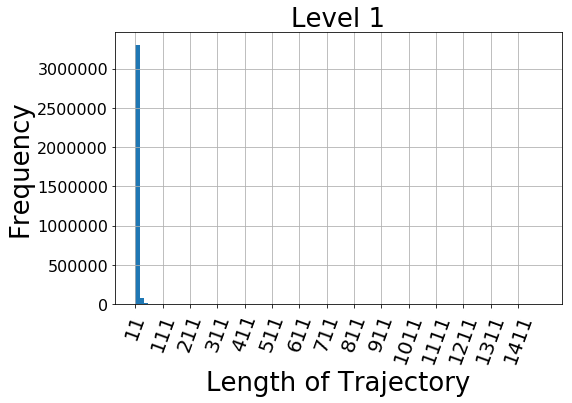

In [5]:
plt.figure(figsize=(8,5))
df.seq_len.hist(bins =100)
plt.xlabel("Length of Trajectory",fontsize=26)
plt.ylabel("Frequency",fontsize=26)
plt.title("Level 1",fontsize=26)
plt.xticks(np.arange(min(df.seq_len), max(df.seq_len)+1, 100),fontsize=20,rotation=70)
plt.yticks(fontsize=16)
plt.show()

### Extract Lat Lon from Trajectories

In [8]:
lat_lng =[]
#lat_lng_time = []
counter = 0
counter2 = 0
def fn(row):
    l1 = []
    l2 = []
    for each_recording in eval(row["loc_info"]):
        _,lat,lng,time = each_recording
        l1.append([lat,lng])
        #l2.append([lat,lng,time])
    lat_lng.append(l1)
    #lat_lng_time.append(l2)


In [9]:
df[["loc_info"]].apply(lambda x: fn(x),axis=1)
df=None

In [10]:
len(lat_lng)

3409396

##  train split

In [11]:
X_train = []
Y_train = []

for each_traj in lat_lng[0:5000]:
    X_train.append(each_traj[:len(each_traj)-1])
    Y_train.append(each_traj[-1])
    

### Model Architectire

In [12]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout,TimeDistributed
from keras.layers import Embedding
from keras.layers import LSTM
import numpy as np
import keras.backend as K


def euclidean_distance_loss(y_true, y_pred):
    """
    Euclidean distance loss
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    euclidean_distance_loss.__name__ = "Custom Loss"
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

model = Sequential()
model.add(LSTM(256, return_sequences=True,input_shape=(None, 2))) 
model.add(LSTM(128, return_sequences=True)) 
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(2))
model.compile(loss=euclidean_distance_loss, optimizer='adam')
model.summary()


Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 256)         265216    
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 128)         197120    
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 524,226
Trainable params: 524,226
Non-trainable params: 0
_________________________________________________________________


### Online Learning (Batch Size = 1)

In [13]:
counter = 0
loss = []
for x_seq,label in zip(X_train,Y_train):
    counter +=1
    if counter %10 ==0:
        print("# {} examples trained".format(counter))
    X_seq = np.array(x_seq).reshape(-1,len(x_seq), 2)
    y = np.array(label).reshape(1, 2) # predict next element
    history = model.fit(X_seq, y, batch_size=1, verbose=1, shuffle=False)
    loss.extend(history.history['loss'])

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 103.8951
Epoch 1/1
1/1 [==============================] - 0s 337ms/step - loss: 103.2041
Epoch 1/1
1/1 [==============================] - 0s 164ms/step - loss: 102.7448
Epoch 1/1
1/1 [==============================] - 0s 129ms/step - loss: 102.4371
Epoch 1/1
1/1 [==============================] - 0s 90ms/step - loss: 102.2191
Epoch 1/1
1/1 [==============================] - 0s 82ms/step - loss: 102.0006
Epoch 1/1
1/1 [==============================] - 0s 74ms/step - loss: 101.7963
Epoch 1/1
1/1 [==============================] - 0s 324ms/step - loss: 101.5330
Epoch 1/1
1/1 [==============================] - 0s 336ms/step - loss: 101.3254
# 10 examples trained
Epoch 1/1
1/1 [==============================] - 0s 96ms/step - loss: 101.1351
Epoch 1/1
1/1 [==============================] - 0s 169ms/step - loss: 100.9387
Epoch 1/1
1/1 [==============================] - 0s 97ms/

# 100 examples trained
Epoch 1/1
1/1 [==============================] - 1s 818ms/step - loss: 95.1549
Epoch 1/1
1/1 [==============================] - 0s 49ms/step - loss: 95.1199
Epoch 1/1
1/1 [==============================] - 0s 81ms/step - loss: 95.0847
Epoch 1/1
1/1 [==============================] - 0s 77ms/step - loss: 95.0493
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 95.0141
Epoch 1/1
1/1 [==============================] - 0s 137ms/step - loss: 94.9790
Epoch 1/1
1/1 [==============================] - 0s 118ms/step - loss: 94.9438
Epoch 1/1
1/1 [==============================] - 0s 207ms/step - loss: 94.9081
Epoch 1/1
1/1 [==============================] - 0s 64ms/step - loss: 94.8738
Epoch 1/1
1/1 [==============================] - 0s 64ms/step - loss: 94.8386
# 110 examples trained
Epoch 1/1
1/1 [==============================] - 0s 113ms/step - loss: 94.8031
Epoch 1/1
1/1 [==============================] - 1s 696ms/step - loss: 94.7684
Epoch 1/1
1/

Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 91.6753
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 91.6419
Epoch 1/1
1/1 [==============================] - 0s 97ms/step - loss: 91.6074
Epoch 1/1
1/1 [==============================] - 0s 254ms/step - loss: 91.5748
Epoch 1/1
1/1 [==============================] - 0s 77ms/step - loss: 91.5418
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 91.5083
Epoch 1/1
1/1 [==============================] - 0s 172ms/step - loss: 91.4745
Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 91.4417
# 210 examples trained
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 91.4081
Epoch 1/1
1/1 [==============================] - 0s 336ms/step - loss: 91.3749
Epoch 1/1
1/1 [==============================] - 0s 147ms/step - loss: 91.3407
Epoch 1/1
1/1 [==============================] - 0s 445ms/step - loss: 91.3073
Epoch 1/1
1/1 [=======================

Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 88.2658
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 88.2333
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 88.2001
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 88.1682
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 88.1352
# 310 examples trained
Epoch 1/1
1/1 [==============================] - 0s 352ms/step - loss: 88.1026
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 88.0686
Epoch 1/1
1/1 [==============================] - 1s 754ms/step - loss: 88.0358
Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 88.0039
Epoch 1/1
1/1 [==============================] - 1s 851ms/step - loss: 87.9710
Epoch 1/1
1/1 [==============================] - 6s 6s/step - loss: 87.9373
Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 87.9045
Epoch 1/1
1/1 [==============================] - 4s 4s

Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 84.8636
# 410 examples trained
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 84.8309
Epoch 1/1
1/1 [==============================] - 1s 804ms/step - loss: 84.7984
Epoch 1/1
1/1 [==============================] - 6s 6s/step - loss: 84.7658
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 84.7332
Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 84.7006
Epoch 1/1
1/1 [==============================] - 4s 4s/step - loss: 84.6681
Epoch 1/1
1/1 [==============================] - 1s 961ms/step - loss: 84.6357
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 84.6037
Epoch 1/1
1/1 [==============================] - 7s 7s/step - loss: 84.5703
Epoch 1/1
1/1 [==============================] - 5s 5s/step - loss: 84.5377
# 420 examples trained
Epoch 1/1
1/1 [==============================] - 5s 5s/step - loss: 84.5061
Epoch 1/1
1/1 [=====================

1/1 [==============================] - 3s 3s/step - loss: 81.5150
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 81.4827
Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 81.4501
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 81.4177
Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 81.3853
Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 81.3529
Epoch 1/1
1/1 [==============================] - 0s 123ms/step - loss: 81.3204
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 81.2880
# 520 examples trained
Epoch 1/1
1/1 [==============================] - 0s 429ms/step - loss: 81.2557
Epoch 1/1
1/1 [==============================] - 6s 6s/step - loss: 81.2234
Epoch 1/1
1/1 [==============================] - 0s 317ms/step - loss: 81.1912
Epoch 1/1
1/1 [==============================] - 0s 45ms/step - loss: 81.1591
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - 

Epoch 1/1
1/1 [==============================] - 0s 62ms/step - loss: 78.1783
Epoch 1/1
1/1 [==============================] - 6s 6s/step - loss: 78.1467
Epoch 1/1
1/1 [==============================] - 0s 57ms/step - loss: 78.1142
Epoch 1/1
1/1 [==============================] - 0s 122ms/step - loss: 78.0818
Epoch 1/1
1/1 [==============================] - 0s 143ms/step - loss: 78.0495
# 620 examples trained
Epoch 1/1
1/1 [==============================] - 0s 70ms/step - loss: 78.0172
Epoch 1/1
1/1 [==============================] - 0s 62ms/step - loss: 77.9847
Epoch 1/1
1/1 [==============================] - 0s 70ms/step - loss: 77.9523
Epoch 1/1
1/1 [==============================] - 0s 360ms/step - loss: 77.9193
Epoch 1/1
1/1 [==============================] - 4s 4s/step - loss: 77.8879
Epoch 1/1
1/1 [==============================] - 5s 5s/step - loss: 77.8553
Epoch 1/1
1/1 [==============================] - 4s 4s/step - loss: 77.8232
Epoch 1/1
1/1 [==============================]

1/1 [==============================] - 0s 88ms/step - loss: 74.8506
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 74.8173
# 720 examples trained
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 74.7850
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 74.7527
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 74.7204
Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 74.6882
Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 74.6560
Epoch 1/1
1/1 [==============================] - 0s 354ms/step - loss: 74.6235
Epoch 1/1
1/1 [==============================] - 0s 428ms/step - loss: 74.5916
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 74.5594
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 74.5267
Epoch 1/1
1/1 [==============================] - 0s 82ms/step - loss: 74.4955
# 730 examples trained
Epoch 1/1
1/1 [===========================

Epoch 1/1
1/1 [==============================] - 0s 73ms/step - loss: 71.5282
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 71.4958
Epoch 1/1
1/1 [==============================] - 1s 857ms/step - loss: 71.4627
Epoch 1/1
1/1 [==============================] - 1s 593ms/step - loss: 71.4311
Epoch 1/1
1/1 [==============================] - 1s 713ms/step - loss: 71.3989
Epoch 1/1
1/1 [==============================] - 1s 998ms/step - loss: 71.3667
Epoch 1/1
1/1 [==============================] - 1s 743ms/step - loss: 71.3345
Epoch 1/1
1/1 [==============================] - 0s 246ms/step - loss: 71.3022
Epoch 1/1
1/1 [==============================] - 0s 440ms/step - loss: 71.2700
# 830 examples trained
Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 71.2377
Epoch 1/1
1/1 [==============================] - 4s 4s/step - loss: 71.2055
Epoch 1/1
1/1 [==============================] - 4s 4s/step - loss: 71.1733
Epoch 1/1
1/1 [=========================

Epoch 1/1
1/1 [==============================] - 0s 150ms/step - loss: 68.2103
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 68.1782
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 68.1460
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 68.1132
Epoch 1/1
1/1 [==============================] - 0s 51ms/step - loss: 68.0814
Epoch 1/1
1/1 [==============================] - 0s 125ms/step - loss: 68.0495
# 930 examples trained
Epoch 1/1
1/1 [==============================] - 0s 95ms/step - loss: 68.0171
Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 67.9850
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 67.9527
Epoch 1/1
1/1 [==============================] - 1s 917ms/step - loss: 67.9206
Epoch 1/1
1/1 [==============================] - 0s 119ms/step - loss: 67.8886
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 67.8557
Epoch 1/1
1/1 [========================

Epoch 1/1
1/1 [==============================] - 0s 153ms/step - loss: 64.8952
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 64.8636
Epoch 1/1
1/1 [==============================] - 0s 173ms/step - loss: 64.8309
# 1030 examples trained
Epoch 1/1
1/1 [==============================] - 0s 291ms/step - loss: 64.7986
Epoch 1/1
1/1 [==============================] - 0s 77ms/step - loss: 64.7670
Epoch 1/1
1/1 [==============================] - 0s 379ms/step - loss: 64.7352
Epoch 1/1
1/1 [==============================] - 5s 5s/step - loss: 64.7021
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 64.6699
Epoch 1/1
1/1 [==============================] - 1s 597ms/step - loss: 64.6377
Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 64.6055
Epoch 1/1
1/1 [==============================] - 0s 131ms/step - loss: 64.5734
Epoch 1/1
1/1 [==============================] - 0s 238ms/step - loss: 64.5412
Epoch 1/1
1/1 [==========================

# 1130 examples trained
Epoch 1/1
1/1 [==============================] - 5s 5s/step - loss: 61.5845
Epoch 1/1
1/1 [==============================] - 0s 345ms/step - loss: 61.5513
Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 61.5192
Epoch 1/1
1/1 [==============================] - 5s 5s/step - loss: 61.4870
Epoch 1/1
1/1 [==============================] - 4s 4s/step - loss: 61.4549
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 61.4228
Epoch 1/1
1/1 [==============================] - 0s 256ms/step - loss: 61.3906
Epoch 1/1
1/1 [==============================] - 0s 96ms/step - loss: 61.3584
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 61.3263
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 61.2941
# 1140 examples trained
Epoch 1/1
1/1 [==============================] - 5s 5s/step - loss: 61.2626
Epoch 1/1
1/1 [==============================] - 4s 4s/step - loss: 61.2305
Epoch 1/1
1/1 [===============

Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 58.2752
Epoch 1/1
1/1 [==============================] - 1s 659ms/step - loss: 58.2430
Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 58.2108
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 58.1788
Epoch 1/1
1/1 [==============================] - 0s 73ms/step - loss: 58.1464
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 58.1146
Epoch 1/1
1/1 [==============================] - 0s 77ms/step - loss: 58.0821
# 1240 examples trained
Epoch 1/1
1/1 [==============================] - 0s 69ms/step - loss: 58.0504
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 58.0180
Epoch 1/1
1/1 [==============================] - 0s 65ms/step - loss: 57.9859
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 57.9538
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 57.9216
Epoch 1/1
1/1 [========================

Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 54.9675
Epoch 1/1
1/1 [==============================] - 0s 64ms/step - loss: 54.9353
Epoch 1/1
1/1 [==============================] - 0s 70ms/step - loss: 54.9032
Epoch 1/1
1/1 [==============================] - 1s 567ms/step - loss: 54.8701
# 1340 examples trained
Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 54.8381
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 54.8060
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 54.7745
Epoch 1/1
1/1 [==============================] - 0s 230ms/step - loss: 54.7417
Epoch 1/1
1/1 [==============================] - 0s 489ms/step - loss: 54.7096
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 54.6775
Epoch 1/1
1/1 [==============================] - 0s 293ms/step - loss: 54.6454
Epoch 1/1
1/1 [==============================] - 0s 147ms/step - loss: 54.6133
Epoch 1/1
1/1 [============================

Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 51.6613
# 1440 examples trained
Epoch 1/1
1/1 [==============================] - 0s 81ms/step - loss: 51.6285
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 51.5972
Epoch 1/1
1/1 [==============================] - 0s 78ms/step - loss: 51.5653
Epoch 1/1
1/1 [==============================] - 1s 942ms/step - loss: 51.5330
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 51.5005
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 51.4687
Epoch 1/1
1/1 [==============================] - 0s 130ms/step - loss: 51.4367
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 51.4046
Epoch 1/1
1/1 [==============================] - 0s 67ms/step - loss: 51.3719
Epoch 1/1
1/1 [==============================] - 0s 74ms/step - loss: 51.3402
# 1450 examples trained
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 51.3086
Epoch 1/1
1/1 [=

Epoch 1/1
1/1 [==============================] - 0s 291ms/step - loss: 48.3878
Epoch 1/1
1/1 [==============================] - 0s 444ms/step - loss: 48.3557
Epoch 1/1
1/1 [==============================] - 0s 207ms/step - loss: 48.3235
Epoch 1/1
1/1 [==============================] - 0s 411ms/step - loss: 48.2916
Epoch 1/1
1/1 [==============================] - 0s 337ms/step - loss: 48.2596
Epoch 1/1
1/1 [==============================] - 0s 142ms/step - loss: 48.2273
Epoch 1/1
1/1 [==============================] - 0s 146ms/step - loss: 48.1955
Epoch 1/1
1/1 [==============================] - 0s 78ms/step - loss: 48.1634
Epoch 1/1
1/1 [==============================] - 1s 747ms/step - loss: 48.1322
# 1550 examples trained
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 48.0995
Epoch 1/1
1/1 [==============================] - 0s 70ms/step - loss: 48.0675
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 48.0354
Epoch 1/1
1/1 [=================

1/1 [==============================] - 1s 544ms/step - loss: 45.1164
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 45.0843
Epoch 1/1
1/1 [==============================] - 0s 125ms/step - loss: 45.0520
Epoch 1/1
1/1 [==============================] - 0s 150ms/step - loss: 45.0203
Epoch 1/1
1/1 [==============================] - 0s 121ms/step - loss: 44.9882
Epoch 1/1
1/1 [==============================] - 0s 95ms/step - loss: 44.9559
Epoch 1/1
1/1 [==============================] - 1s 778ms/step - loss: 44.9237
# 1650 examples trained
Epoch 1/1
1/1 [==============================] - 0s 67ms/step - loss: 44.8926
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 44.8606
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 44.8275
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 44.7954
Epoch 1/1
1/1 [==============================] - 0s 121ms/step - loss: 44.7643
Epoch 1/1
1/1 [==============================] - 0

Epoch 1/1
1/1 [==============================] - 0s 67ms/step - loss: 41.8145
Epoch 1/1
1/1 [==============================] - 0s 85ms/step - loss: 41.7824
Epoch 1/1
1/1 [==============================] - 0s 51ms/step - loss: 41.7503
Epoch 1/1
1/1 [==============================] - 0s 182ms/step - loss: 41.7179
# 1750 examples trained
Epoch 1/1
1/1 [==============================] - 0s 365ms/step - loss: 41.6858
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 41.6538
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 41.6219
Epoch 1/1
1/1 [==============================] - 0s 99ms/step - loss: 41.5895
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 41.5573
Epoch 1/1
1/1 [==============================] - 1s 846ms/step - loss: 41.5258
Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 41.4931
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 41.4617
Epoch 1/1
1/1 [========================

Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 38.5443
Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 38.5121
# 1850 examples trained
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 38.4804
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 38.4477
Epoch 1/1
1/1 [==============================] - 0s 92ms/step - loss: 38.4164
Epoch 1/1
1/1 [==============================] - 0s 260ms/step - loss: 38.3830
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 38.3515
Epoch 1/1
1/1 [==============================] - 0s 77ms/step - loss: 38.3197
Epoch 1/1
1/1 [==============================] - 0s 220ms/step - loss: 38.2879
Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 38.2559
Epoch 1/1
1/1 [==============================] - 0s 270ms/step - loss: 38.2240
Epoch 1/1
1/1 [==============================] - 0s 122ms/step - loss: 38.1920
# 1860 examples trained
Epoch 1/1
1/1 [=

# 1950 examples trained
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 35.2750
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 35.2430
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 35.2109
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 35.1789
Epoch 1/1
1/1 [==============================] - 0s 61ms/step - loss: 35.1468
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 35.1148
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 35.0830
Epoch 1/1
1/1 [==============================] - 0s 73ms/step - loss: 35.0508
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 35.0185
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 34.9869
# 1960 examples trained
Epoch 1/1
1/1 [==============================] - 0s 51ms/step - loss: 34.9549
Epoch 1/1
1/1 [==============================] - 0s 91ms/step - loss: 34.9228
Epoch 1/1
1/1 [=

Epoch 1/1
1/1 [==============================] - 0s 291ms/step - loss: 32.0067
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 31.9747
Epoch 1/1
1/1 [==============================] - 0s 74ms/step - loss: 31.9426
Epoch 1/1
1/1 [==============================] - 0s 77ms/step - loss: 31.9106
Epoch 1/1
1/1 [==============================] - 0s 73ms/step - loss: 31.8785
Epoch 1/1
1/1 [==============================] - 0s 70ms/step - loss: 31.8465
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 31.8144
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 31.7824
# 2060 examples trained
Epoch 1/1
1/1 [==============================] - 0s 69ms/step - loss: 31.7499
Epoch 1/1
1/1 [==============================] - 0s 58ms/step - loss: 31.7183
Epoch 1/1
1/1 [==============================] - 0s 62ms/step - loss: 31.6863
Epoch 1/1
1/1 [==============================] - 0s 173ms/step - loss: 31.6542
Epoch 1/1
1/1 [=======================

Epoch 1/1
1/1 [==============================] - 0s 82ms/step - loss: 28.7385
Epoch 1/1
1/1 [==============================] - 0s 58ms/step - loss: 28.7065
Epoch 1/1
1/1 [==============================] - 0s 65ms/step - loss: 28.6742
Epoch 1/1
1/1 [==============================] - 0s 69ms/step - loss: 28.6421
Epoch 1/1
1/1 [==============================] - 0s 58ms/step - loss: 28.6100
Epoch 1/1
1/1 [==============================] - 0s 335ms/step - loss: 28.5780
# 2160 examples trained
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 28.5460
Epoch 1/1
1/1 [==============================] - 0s 62ms/step - loss: 28.5140
Epoch 1/1
1/1 [==============================] - 0s 70ms/step - loss: 28.4819
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 28.4499
Epoch 1/1
1/1 [==============================] - 0s 58ms/step - loss: 28.4178
Epoch 1/1
1/1 [==============================] - 0s 65ms/step - loss: 28.3858
Epoch 1/1
1/1 [========================

Epoch 1/1
1/1 [==============================] - 0s 65ms/step - loss: 25.4706
Epoch 1/1
1/1 [==============================] - 0s 170ms/step - loss: 25.4386
Epoch 1/1
1/1 [==============================] - 0s 78ms/step - loss: 25.4066
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 25.3745
# 2260 examples trained
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 25.3428
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 25.3107
Epoch 1/1
1/1 [==============================] - 0s 77ms/step - loss: 25.2787
Epoch 1/1
1/1 [==============================] - 6s 6s/step - loss: 25.2467
Epoch 1/1
1/1 [==============================] - 0s 116ms/step - loss: 25.2146
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 25.1826
Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 25.1505
Epoch 1/1
1/1 [==============================] - 0s 69ms/step - loss: 25.1185
Epoch 1/1
1/1 [=========================

Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 22.2030
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 22.1715
# 2360 examples trained
Epoch 1/1
1/1 [==============================] - 0s 73ms/step - loss: 22.1395
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 22.1075
Epoch 1/1
1/1 [==============================] - 0s 62ms/step - loss: 22.0755
Epoch 1/1
1/1 [==============================] - 0s 70ms/step - loss: 22.0434
Epoch 1/1
1/1 [==============================] - 0s 77ms/step - loss: 22.0114
Epoch 1/1
1/1 [==============================] - 0s 51ms/step - loss: 21.9794
Epoch 1/1
1/1 [==============================] - 0s 47ms/step - loss: 21.9474
Epoch 1/1
1/1 [==============================] - 1s 512ms/step - loss: 21.9142
Epoch 1/1
1/1 [==============================] - 0s 441ms/step - loss: 21.8821
Epoch 1/1
1/1 [==============================] - 1s 963ms/step - loss: 21.8501
# 2370 examples trained
Epoch 1/1
1/1

# 2460 examples trained
Epoch 1/1
1/1 [==============================] - 0s 62ms/step - loss: 18.9364
Epoch 1/1
1/1 [==============================] - 0s 51ms/step - loss: 18.9044
Epoch 1/1
1/1 [==============================] - 0s 47ms/step - loss: 18.8724
Epoch 1/1
1/1 [==============================] - 0s 62ms/step - loss: 18.8404
Epoch 1/1
1/1 [==============================] - 0s 58ms/step - loss: 18.8083
Epoch 1/1
1/1 [==============================] - 0s 58ms/step - loss: 18.7765
Epoch 1/1
1/1 [==============================] - 0s 70ms/step - loss: 18.7445
Epoch 1/1
1/1 [==============================] - 0s 58ms/step - loss: 18.7124
Epoch 1/1
1/1 [==============================] - 0s 51ms/step - loss: 18.6804
Epoch 1/1
1/1 [==============================] - 0s 47ms/step - loss: 18.6480
# 2470 examples trained
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 18.6163
Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 18.5843
Epoch 1/1
1/1 [===

Epoch 1/1
1/1 [==============================] - 0s 51ms/step - loss: 15.6698
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 15.6377
Epoch 1/1
1/1 [==============================] - 0s 277ms/step - loss: 15.6058
Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 15.5735
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 15.5417
Epoch 1/1
1/1 [==============================] - 0s 62ms/step - loss: 15.5096
Epoch 1/1
1/1 [==============================] - 1s 747ms/step - loss: 15.4776
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 15.4456
# 2570 examples trained
Epoch 1/1
1/1 [==============================] - 0s 61ms/step - loss: 15.4135
Epoch 1/1
1/1 [==============================] - 0s 118ms/step - loss: 15.3815
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 15.3496
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 15.3171
Epoch 1/1
1/1 [==========================

Epoch 1/1
1/1 [==============================] - 0s 178ms/step - loss: 12.4035
Epoch 1/1
1/1 [==============================] - 0s 93ms/step - loss: 12.3716
Epoch 1/1
1/1 [==============================] - 0s 58ms/step - loss: 12.3396
Epoch 1/1
1/1 [==============================] - 0s 114ms/step - loss: 12.3074
Epoch 1/1
1/1 [==============================] - 0s 64ms/step - loss: 12.2753
Epoch 1/1
1/1 [==============================] - 0s 250ms/step - loss: 12.2434
# 2670 examples trained
Epoch 1/1
1/1 [==============================] - 0s 47ms/step - loss: 12.2113
Epoch 1/1
1/1 [==============================] - 0s 67ms/step - loss: 12.1792
Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 12.1473
Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 12.1153
Epoch 1/1
1/1 [==============================] - 5s 5s/step - loss: 12.0831
Epoch 1/1
1/1 [==============================] - 4s 4s/step - loss: 12.0513
Epoch 1/1
1/1 [============================

Epoch 1/1
1/1 [==============================] - 0s 99ms/step - loss: 9.1054
Epoch 1/1
1/1 [==============================] - 0s 58ms/step - loss: 9.0732
Epoch 1/1
1/1 [==============================] - 0s 389ms/step - loss: 9.0411
# 2770 examples trained
Epoch 1/1
1/1 [==============================] - 0s 72ms/step - loss: 9.0091
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 8.9771
Epoch 1/1
1/1 [==============================] - 0s 62ms/step - loss: 8.9451
Epoch 1/1
1/1 [==============================] - 0s 51ms/step - loss: 8.9131
Epoch 1/1
1/1 [==============================] - 0s 74ms/step - loss: 8.8811
Epoch 1/1
1/1 [==============================] - 0s 51ms/step - loss: 8.8491
Epoch 1/1
1/1 [==============================] - 0s 51ms/step - loss: 8.8171
Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 8.7850
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 8.7531
Epoch 1/1
1/1 [==============================] - 0s

Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 5.7757
Epoch 1/1
1/1 [==============================] - 0s 69ms/step - loss: 5.7435
Epoch 1/1
1/1 [==============================] - 0s 276ms/step - loss: 5.7104
Epoch 1/1
1/1 [==============================] - 1s 881ms/step - loss: 5.6793
Epoch 1/1
1/1 [==============================] - 0s 82ms/step - loss: 5.6475
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 5.6153
Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 5.5835
Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 5.5514
Epoch 1/1
1/1 [==============================] - 6s 6s/step - loss: 5.5194
# 2880 examples trained
Epoch 1/1
1/1 [==============================] - 0s 109ms/step - loss: 5.4871
Epoch 1/1
1/1 [==============================] - 0s 145ms/step - loss: 5.4547
Epoch 1/1
1/1 [==============================] - 0s 67ms/step - loss: 5.4232
Epoch 1/1
1/1 [==============================] - 0s 97

Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 2.4459
Epoch 1/1
1/1 [==============================] - 0s 56ms/step - loss: 2.4137
Epoch 1/1
1/1 [==============================] - 0s 74ms/step - loss: 2.3818
Epoch 1/1
1/1 [==============================] - 0s 73ms/step - loss: 2.3495
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 2.3178
# 2980 examples trained
Epoch 1/1
1/1 [==============================] - 0s 81ms/step - loss: 2.2857
Epoch 1/1
1/1 [==============================] - 0s 118ms/step - loss: 2.2537
Epoch 1/1
1/1 [==============================] - 0s 106ms/step - loss: 2.2217
Epoch 1/1
1/1 [==============================] - 0s 62ms/step - loss: 2.1895
Epoch 1/1
1/1 [==============================] - 0s 73ms/step - loss: 2.1575
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 2.1252
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 2.0934
Epoch 1/1
1/1 [==============================] - 0s 

Epoch 1/1
1/1 [==============================] - 0s 297ms/step - loss: 0.0287
# 3080 examples trained
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 0.0284
Epoch 1/1
1/1 [==============================] - 5s 5s/step - loss: 0.0246
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0269
Epoch 1/1
1/1 [==============================] - 0s 252ms/step - loss: 0.0172
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 0.0195
Epoch 1/1
1/1 [==============================] - 1s 947ms/step - loss: 0.0084
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 0.0305
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 0.0362
Epoch 1/1
1/1 [==============================] - 0s 134ms/step - loss: 0.0204
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 0.0307
# 3090 examples trained
Epoch 1/1
1/1 [==============================] - 4s 4s/step - loss: 0.0377
Epoch 1/1
1/1 [===============

Epoch 1/1
1/1 [==============================] - 1s 678ms/step - loss: 0.0129
Epoch 1/1
1/1 [==============================] - 0s 398ms/step - loss: 0.0178
Epoch 1/1
1/1 [==============================] - 0s 88ms/step - loss: 0.0110
Epoch 1/1
1/1 [==============================] - 0s 46ms/step - loss: 0.0060
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 0.0102
Epoch 1/1
1/1 [==============================] - 0s 80ms/step - loss: 0.0044
Epoch 1/1
1/1 [==============================] - 0s 117ms/step - loss: 0.0109
Epoch 1/1
1/1 [==============================] - 0s 62ms/step - loss: 0.0147
# 3190 examples trained
Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 0.0074
Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 0.0089
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 0.0131
Epoch 1/1
1/1 [==============================] - 0s 220ms/step - loss: 0.0074
Epoch 1/1
1/1 [==============================] - 3

Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 0.0043
Epoch 1/1
1/1 [==============================] - 0s 78ms/step - loss: 0.0068
Epoch 1/1
1/1 [==============================] - 0s 264ms/step - loss: 0.0097
Epoch 1/1
1/1 [==============================] - 0s 84ms/step - loss: 0.0052
# 3290 examples trained
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 0.0062
Epoch 1/1
1/1 [==============================] - 0s 43ms/step - loss: 0.0090
Epoch 1/1
1/1 [==============================] - 0s 110ms/step - loss: 0.0053
Epoch 1/1
1/1 [==============================] - 0s 62ms/step - loss: 0.0068
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 0.0092
Epoch 1/1
1/1 [==============================] - 0s 79ms/step - loss: 0.0051
Epoch 1/1
1/1 [==============================] - 0s 58ms/step - loss: 0.0061
Epoch 1/1
1/1 [==============================] - 0s 51ms/step - loss: 0.0092
Epoch 1/1
1/1 [==============================] - 2

# 3390 examples trained
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0075
Epoch 1/1
1/1 [==============================] - 0s 103ms/step - loss: 0.0035
Epoch 1/1
1/1 [==============================] - 1s 967ms/step - loss: 0.0059
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0072
Epoch 1/1
1/1 [==============================] - 1s 535ms/step - loss: 0.0039
Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 0.0059
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 0.0069
Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 0.0035
Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 0.0060
Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 0.0057
# 3400 examples trained
Epoch 1/1
1/1 [==============================] - 0s 99ms/step - loss: 0.0024
Epoch 1/1
1/1 [==============================] - 0s 199ms/step - loss: 0.0067
Epoch 1/1
1/1 [===================

Epoch 1/1
1/1 [==============================] - 0s 65ms/step - loss: 0.0021
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 0.0041
Epoch 1/1
1/1 [==============================] - 0s 73ms/step - loss: 0.0059
Epoch 1/1
1/1 [==============================] - 0s 81ms/step - loss: 0.0032
Epoch 1/1
1/1 [==============================] - 0s 51ms/step - loss: 0.0027
Epoch 1/1
1/1 [==============================] - 0s 69ms/step - loss: 0.0049
# 3500 examples trained
Epoch 1/1
1/1 [==============================] - 0s 51ms/step - loss: 0.0030
Epoch 1/1
1/1 [==============================] - 0s 146ms/step - loss: 0.0026
Epoch 1/1
1/1 [==============================] - 0s 118ms/step - loss: 0.0042
Epoch 1/1
1/1 [==============================] - 0s 242ms/step - loss: 0.0013
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 0.0045
Epoch 1/1
1/1 [==============================] - 0s 58ms/step - loss: 0.0053
Epoch 1/1
1/1 [==============================] - 

Epoch 1/1
1/1 [==============================] - 0s 77ms/step - loss: 0.0057
Epoch 1/1
1/1 [==============================] - 0s 77ms/step - loss: 0.0053
Epoch 1/1
1/1 [==============================] - 0s 124ms/step - loss: 0.0014
# 3600 examples trained
Epoch 1/1
1/1 [==============================] - 0s 117ms/step - loss: 0.0064
Epoch 1/1
1/1 [==============================] - 0s 88ms/step - loss: 0.0077
Epoch 1/1
1/1 [==============================] - 6s 6s/step - loss: 0.0031
Epoch 1/1
1/1 [==============================] - 1s 643ms/step - loss: 0.0056
Epoch 1/1
1/1 [==============================] - 0s 92ms/step - loss: 0.0083
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 0.0055
Epoch 1/1
1/1 [==============================] - 0s 70ms/step - loss: 0.0026
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0045
Epoch 1/1
1/1 [==============================] - 1s 976ms/step - loss: 0.0025
Epoch 1/1
1/1 [==============================] - 1s 

1/1 [==============================] - 0s 81ms/step - loss: 0.0057
Epoch 1/1
1/1 [==============================] - 0s 67ms/step - loss: 0.0022
Epoch 1/1
1/1 [==============================] - 0s 79ms/step - loss: 0.0047
Epoch 1/1
1/1 [==============================] - 0s 75ms/step - loss: 0.0051
Epoch 1/1
1/1 [==============================] - 0s 69ms/step - loss: 0.0016
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 0.0064
Epoch 1/1
1/1 [==============================] - 0s 459ms/step - loss: 0.0086
Epoch 1/1
1/1 [==============================] - 0s 146ms/step - loss: 0.0067
Epoch 1/1
1/1 [==============================] - 0s 130ms/step - loss: 0.0026
Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 0.0057
# 3710 examples trained
Epoch 1/1
1/1 [==============================] - 0s 117ms/step - loss: 0.0075
Epoch 1/1
1/1 [==============================] - 0s 356ms/step - loss: 0.0041
Epoch 1/1
1/1 [==============================] - 1s 647ms

Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 0.0026
Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 0.0031
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0023
Epoch 1/1
1/1 [==============================] - 0s 138ms/step - loss: 0.0016
Epoch 1/1
1/1 [==============================] - 0s 103ms/step - loss: 0.0040
Epoch 1/1
1/1 [==============================] - 0s 363ms/step - loss: 0.0025
# 3810 examples trained
Epoch 1/1
1/1 [==============================] - 0s 88ms/step - loss: 0.0025
Epoch 1/1
1/1 [==============================] - 0s 477ms/step - loss: 0.0025
Epoch 1/1
1/1 [==============================] - 0s 134ms/step - loss: 0.0025
Epoch 1/1
1/1 [==============================] - 1s 551ms/step - loss: 0.0020
Epoch 1/1
1/1 [==============================] - 1s 562ms/step - loss: 0.0036
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 0.0037
Epoch 1/1
1/1 [==============================] - 0s

Epoch 1/1
1/1 [==============================] - 0s 130ms/step - loss: 0.0042
Epoch 1/1
1/1 [==============================] - 0s 121ms/step - loss: 0.0031
# 3910 examples trained
Epoch 1/1
1/1 [==============================] - 0s 77ms/step - loss: 0.0026
Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 0.0011
Epoch 1/1
1/1 [==============================] - 0s 152ms/step - loss: 0.0031
Epoch 1/1
1/1 [==============================] - 1s 824ms/step - loss: 0.0016
Epoch 1/1
1/1 [==============================] - 0s 64ms/step - loss: 0.0052
Epoch 1/1
1/1 [==============================] - 0s 135ms/step - loss: 0.0045
Epoch 1/1
1/1 [==============================] - 0s 78ms/step - loss: 0.0015
Epoch 1/1
1/1 [==============================] - 1s 618ms/step - loss: 0.0047
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 0.0046
Epoch 1/1
1/1 [==============================] - 0s 78ms/step - loss: 0.0021
# 3920 examples trained
Epoch 1/1
1/1 [===========

Epoch 1/1
1/1 [==============================] - 0s 82ms/step - loss: 0.0051
Epoch 1/1
1/1 [==============================] - 0s 96ms/step - loss: 0.0049
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 0.0101
Epoch 1/1
1/1 [==============================] - 0s 92ms/step - loss: 0.0105
Epoch 1/1
1/1 [==============================] - 4s 4s/step - loss: 0.0071
Epoch 1/1
1/1 [==============================] - 0s 64ms/step - loss: 0.0015
Epoch 1/1
1/1 [==============================] - 0s 69ms/step - loss: 0.0078
Epoch 1/1
1/1 [==============================] - 0s 67ms/step - loss: 0.0106
Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 0.0087
# 4020 examples trained
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 0.0028
Epoch 1/1
1/1 [==============================] - 0s 76ms/step - loss: 0.0067
Epoch 1/1
1/1 [==============================] - 0s 85ms/step - loss: 0.0106
Epoch 1/1
1/1 [==============================] - 0s 63

1/1 [==============================] - 0s 202ms/step - loss: 0.0043
Epoch 1/1
1/1 [==============================] - 0s 115ms/step - loss: 0.0054
Epoch 1/1
1/1 [==============================] - 0s 74ms/step - loss: 0.0079
Epoch 1/1
1/1 [==============================] - 0s 128ms/step - loss: 0.0054
Epoch 1/1
1/1 [==============================] - 4s 4s/step - loss: 0.0034
Epoch 1/1
1/1 [==============================] - 6s 6s/step - loss: 0.0049
# 4120 examples trained
Epoch 1/1
1/1 [==============================] - 0s 207ms/step - loss: 0.0018
Epoch 1/1
1/1 [==============================] - 5s 5s/step - loss: 0.0055
Epoch 1/1
1/1 [==============================] - 1s 603ms/step - loss: 0.0066
Epoch 1/1
1/1 [==============================] - 0s 263ms/step - loss: 0.0030
Epoch 1/1
1/1 [==============================] - 0s 57ms/step - loss: 0.0047
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 0.0063
Epoch 1/1
1/1 [==============================] - 0s 54ms/step 

1/1 [==============================] - 0s 58ms/step - loss: 0.0036
Epoch 1/1
1/1 [==============================] - 0s 183ms/step - loss: 0.0040
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 0.0019
# 4220 examples trained
Epoch 1/1
1/1 [==============================] - 0s 80ms/step - loss: 0.0029
Epoch 1/1
1/1 [==============================] - 0s 69ms/step - loss: 0.0028
Epoch 1/1
1/1 [==============================] - 0s 259ms/step - loss: 0.0027
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 0.0038
Epoch 1/1
1/1 [==============================] - 0s 228ms/step - loss: 0.0025
Epoch 1/1
1/1 [==============================] - 0s 99ms/step - loss: 0.0047
Epoch 1/1
1/1 [==============================] - 0s 106ms/step - loss: 0.0050
Epoch 1/1
1/1 [==============================] - 0s 224ms/step - loss: 8.8659e-04
Epoch 1/1
1/1 [==============================] - 0s 62ms/step - loss: 0.0050
Epoch 1/1
1/1 [==============================] - 0s 8

# 4320 examples trained
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 0.0035
Epoch 1/1
1/1 [==============================] - 0s 51ms/step - loss: 0.0050
Epoch 1/1
1/1 [==============================] - 0s 121ms/step - loss: 0.0034
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 0.0032
Epoch 1/1
1/1 [==============================] - 0s 69ms/step - loss: 0.0041
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 0.0023
Epoch 1/1
1/1 [==============================] - 1s 700ms/step - loss: 0.0054
Epoch 1/1
1/1 [==============================] - 0s 62ms/step - loss: 0.0073
Epoch 1/1
1/1 [==============================] - 0s 119ms/step - loss: 0.0049
Epoch 1/1
1/1 [==============================] - 0s 150ms/step - loss: 0.0026
# 4330 examples trained
Epoch 1/1
1/1 [==============================] - 0s 62ms/step - loss: 0.0047
Epoch 1/1
1/1 [==============================] - 0s 62ms/step - loss: 0.0038
Epoch 1/1
1/1 [=========

Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 0.0011
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 0.0042
Epoch 1/1
1/1 [==============================] - 0s 66ms/step - loss: 0.0030
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 0.0014
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 0.0013
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 0.0027
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 0.0026
# 4430 examples trained
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 0.0022
Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 0.0018
Epoch 1/1
1/1 [==============================] - 0s 300ms/step - loss: 0.0025
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 0.0023
Epoch 1/1
1/1 [==============================] - 0s 53ms/step - loss: 0.0015
Epoch 1/1
1/1 [==============================] - 0s

1/1 [==============================] - 0s 138ms/step - loss: 0.0047
Epoch 1/1
1/1 [==============================] - 0s 159ms/step - loss: 8.8611e-04
Epoch 1/1
1/1 [==============================] - 0s 74ms/step - loss: 0.0052
Epoch 1/1
1/1 [==============================] - 0s 88ms/step - loss: 0.0059
# 4530 examples trained
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 0.0027
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0045
Epoch 1/1
1/1 [==============================] - 0s 311ms/step - loss: 0.0066
Epoch 1/1
1/1 [==============================] - 0s 67ms/step - loss: 0.0044
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0022
Epoch 1/1
1/1 [==============================] - 0s 53ms/step - loss: 0.0032
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 0.0017
Epoch 1/1
1/1 [==============================] - 0s 80ms/step - loss: 0.0034
Epoch 1/1
1/1 [==============================] - 0s 48ms/st

# 4630 examples trained
Epoch 1/1
1/1 [==============================] - 0s 71ms/step - loss: 0.0017
Epoch 1/1
1/1 [==============================] - 0s 69ms/step - loss: 0.0056
Epoch 1/1
1/1 [==============================] - 0s 47ms/step - loss: 0.0068
Epoch 1/1
1/1 [==============================] - 0s 91ms/step - loss: 0.0035
Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 0.0041
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 0.0068
Epoch 1/1
1/1 [==============================] - 0s 51ms/step - loss: 0.0044
Epoch 1/1
1/1 [==============================] - 0s 51ms/step - loss: 0.0017
Epoch 1/1
1/1 [==============================] - 0s 85ms/step - loss: 0.0025
Epoch 1/1
1/1 [==============================] - 0s 109ms/step - loss: 8.0953e-04
# 4640 examples trained
Epoch 1/1
1/1 [==============================] - 0s 73ms/step - loss: 0.0058
Epoch 1/1
1/1 [==============================] - 0s 61ms/step - loss: 0.0086
Epoch 1/1
1/1 [========

Epoch 1/1
1/1 [==============================] - 0s 62ms/step - loss: 0.0024
Epoch 1/1
1/1 [==============================] - 0s 58ms/step - loss: 0.0034
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 0.0045
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 0.0016
Epoch 1/1
1/1 [==============================] - 0s 68ms/step - loss: 0.0055
Epoch 1/1
1/1 [==============================] - 0s 207ms/step - loss: 0.0077
Epoch 1/1
1/1 [==============================] - 0s 59ms/step - loss: 0.0052
# 4740 examples trained
Epoch 1/1
1/1 [==============================] - 0s 44ms/step - loss: 0.0013
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 0.0026
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 3.1891e-04
Epoch 1/1
1/1 [==============================] - 0s 48ms/step - loss: 0.0019
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 0.0016
Epoch 1/1
1/1 [==============================] 

Epoch 1/1
1/1 [==============================] - 0s 70ms/step - loss: 0.0056
Epoch 1/1
1/1 [==============================] - 0s 73ms/step - loss: 0.0024
Epoch 1/1
1/1 [==============================] - 0s 74ms/step - loss: 0.0042
Epoch 1/1
1/1 [==============================] - 0s 91ms/step - loss: 0.0012
# 4840 examples trained
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 0.0059
Epoch 1/1
1/1 [==============================] - 0s 55ms/step - loss: 0.0092
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 0.0053
Epoch 1/1
1/1 [==============================] - 0s 141ms/step - loss: 0.0034
Epoch 1/1
1/1 [==============================] - 0s 58ms/step - loss: 0.0052
Epoch 1/1
1/1 [==============================] - 0s 51ms/step - loss: 0.0014
Epoch 1/1
1/1 [==============================] - 0s 91ms/step - loss: 0.0060
Epoch 1/1
1/1 [==============================] - 0s 51ms/step - loss: 0.0068
Epoch 1/1
1/1 [==============================] - 0s

Epoch 1/1
1/1 [==============================] - 0s 228ms/step - loss: 0.0057
# 4940 examples trained
Epoch 1/1
1/1 [==============================] - 0s 68ms/step - loss: 0.0039
Epoch 1/1
1/1 [==============================] - 0s 65ms/step - loss: 0.0015
Epoch 1/1
1/1 [==============================] - 0s 78ms/step - loss: 0.0033
Epoch 1/1
1/1 [==============================] - 0s 63ms/step - loss: 0.0011
Epoch 1/1
1/1 [==============================] - 0s 96ms/step - loss: 0.0054
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 0.0049
Epoch 1/1
1/1 [==============================] - 0s 112ms/step - loss: 0.0020
Epoch 1/1
1/1 [==============================] - 0s 52ms/step - loss: 0.0033
Epoch 1/1
1/1 [==============================] - 0s 73ms/step - loss: 0.0030
Epoch 1/1
1/1 [==============================] - 0s 386ms/step - loss: 0.0018
# 4950 examples trained
Epoch 1/1
1/1 [==============================] - 0s 70ms/step - loss: 0.0028
Epoch 1/1
1/1 [============

### Loss VS # of training examples

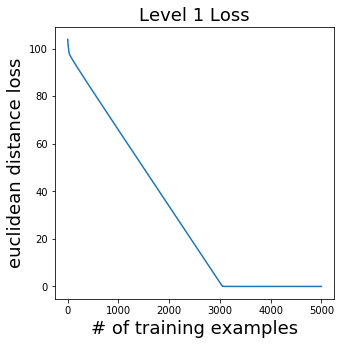

In [14]:
y = loss
x = list(range(1,len(loss)+1))
plt.figure(figsize=(5,5))
plt.plot(x, y)
plt.xlabel("# of training examples",fontsize=18)
plt.ylabel("euclidean distance loss",fontsize=18)
plt.title("Level 1 Loss",fontsize=18)
plt.show()

### Test the model

In [15]:
from scipy.spatial.distance import euclidean

from sklearn.metrics.pairwise import euclidean_distances

test_set =  lat_lng[10000:15000]
predicted_val =[]
for i,each_traj in enumerate(test_set):
    x_test = each_traj[:len(each_traj) -1]
    x_test = np.array(x_test).reshape(1, len(x_test), 2)
    y_test = each_traj[-1]
    y_test = np.array(y_test).reshape(1,2)
    y_pred = model.predict(x_test)
    predicted_val.append(y_pred.tolist()[0])
        
new_predicted_val = []
for sublst in predicted_val:
    for i, val in enumerate(sublst):
        sublst[i] = round(val, 7)
    new_predicted_val.append(sublst)    

### Test Error

In [16]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
error = []
for each_traj,y_pred in zip(test_set,new_predicted_val):
    y_test = each_traj[-1]
    error.extend(euclidean_distances([y_test],[y_pred]))
        
print("test error",np.mean(error))   

test error 0.002936369221322621


### Example plot Predicted vs True Trajectory


  <tr>
    <td> <img src="http://drive.google.com/uc?export=view&id=1teJRtYL5_Y5La59JhD5K1Ye7OsIzfZie" alt="Drawing" style="width: 500px;"/> </td>
    <td> <img src="http://drive.google.com/uc?export=view&id=1Ykh3sqvj6ly9uTznqQa8BtpV-jwVr2Uw" alt="Drawing" style="width: 500px;"/> </td>
    </tr>
    
    
    
    

### Centroids from K- Means models

In [17]:
centroids = [[1.2901505322971618, 103.85151526415854],
 [1.290761314882777, 103.85183701616937],
 [1.2898866212491749, 103.85139324211389],
 [1.2903683538500839, 103.85163185742208],
 [1.2908584102736864, 103.8519792337393],
 [1.290061721528241, 103.85165098408669],
 [1.290055102350767, 103.85144672301637],
 [1.2906218405153758, 103.85173958428693],
 [1.2897596030983194, 103.85130943752183],
 [1.2902503772023322, 103.85156459994279]]

### Calculate Visitors near each Cluster - Using True Label

In [18]:
from sklearn.metrics.pairwise import euclidean_distances
from collections import Counter
calc_cluster = []
for each_traj in lat_lng[10000:15000]:
    label = each_traj[-1]
    label = np.array(label).reshape(1,2)   
    local_cluster = []
    for center in centroids:
        #print(float(euclidean_distances(label.tolist(), [center])[0][0]))
        local_cluster.append(euclidean_distances(label.tolist(), [center])[0][0]) 
    calc_cluster.append(np.argmin(local_cluster))

In [19]:
Counter(calc_cluster)

Counter({4: 2059,
         3: 737,
         9: 238,
         6: 646,
         7: 556,
         8: 290,
         1: 336,
         0: 84,
         2: 54})

### Calculate Visitors near each Cluster - Using Predicted Label

In [21]:
from sklearn.metrics.pairwise import euclidean_distances
from collections import Counter
calc_cluster = []
for each_traj in new_predicted_val:
    label = each_traj
    label = np.array(label).reshape(1,2)   
    local_cluster = []
    for center in centroids:
        #print(float(euclidean_distances(label.tolist(), [center])[0][0]))
        local_cluster.append(euclidean_distances(label.tolist(), [center])[0][0]) 
    calc_cluster.append(np.argmin(local_cluster))

In [22]:
Counter(calc_cluster)

Counter({1: 355,
         6: 750,
         3: 836,
         4: 1762,
         9: 306,
         7: 637,
         0: 94,
         8: 227,
         2: 32,
         5: 1})

In [ ]:
# def np_haversine(latlon1, latlon2):
#     """
#     Numpy version of the Haversine function to calculate distances between two sets of points.
#     Returns the distance in miles.
#     """
#     lat1 = latlon1[:, 0]
#     lon1 = latlon1[:, 1]
#     lat2 = latlon2[:, 0]
#     lon2 = latlon2[:, 1]
    
#     REarth = 3961
#     lat = np.abs(lat1 - lat2) * np.pi / 180
#     lon = np.abs(lon1 - lon2) * np.pi / 180
#     lat1 = lat1 * np.pi / 180
#     lat2 = lat2 * np.pi / 180
#     a = np.sin(lat / 2) * np.sin(lat / 2) + np.cos(lat1) * np.cos(lat2) * np.sin(lon / 2) * np.sin(lon / 2)
#     d = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
#     return REarth * d